In [84]:
import pandas as pd
# import os
import warnings
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns

from functools import reduce
from datetime import datetime
from datetime import date

warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [85]:
pd.set_option('display.max_rows',80)    # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

### ========================================================

In [86]:
externdata_train_uni_columns = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 
                 'Комплектация','fuelType', 'mileage', 'modelDate', 'model', 'numberOfDoors', 
                'productionDate', 'vehicleTransmission', 
                'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'price']

externdata_test_uni_columns = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 
                'equipment_dict','fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 
                'productionDate', 'vehicleTransmission', 'vendor', 
                'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']


### ========================================================

In [87]:
test = pd.read_csv('./Project_7_data/test.csv',low_memory=False)
df= pd.read_csv('./Project_7_data/' + 'auto_ru_2020_09_09.csv',low_memory=False)

df_full= pd.read_csv('./Preproject_7_data/' + 'all_auto_ru_09_09_2020.csv',low_memory=False)

### ===================0909=================================

In [98]:
def externdata_train_bodyType_uni(x):
    res=[]
    x = x.lower() if type(x) == str else x  # <================
    try:
        for body_type in test.bodyType.unique():
            if body_type in x:
                res.append(body_type)
    except Exception: return x
    if not res: 
        return x.split()[0]
    return max(res)

def externdata_train_engineDisplacement_uni(x):
    x = re.findall("\d[.]\d", x)[0] if ((type(x)==str)  and  re.findall("\d[.]\d", x)) else '-9' 
    return float(x)

def externdata_train_equipment_uni(x):
    point = "'available_options': "
    start = x.find(point)+len(point)+2
    finish = x.find("]",start) - 1
    return x[start:finish].split("', '")

def externdata_test_ownership_uni(x):
    try:
        digits = re.findall('\d+',x) 
        if len(digits) == 2: res = int(digits[0])*12 + int(digits[1])
        elif len(digits) == 1 and 'месяц' in x: res = int(digits[0])
        elif len(digits) == 1 and 'месяц' not in x: res = int(digits[0])*12
    except Exception: res = 0   
    return res

def externdata_train_ownership_uni(x):
    tmp = json.loads(x.replace("'",'"'))  if x==x else {'year': 2020, 'month': 9}
    res = (2020 - tmp['year'])*12 + tmp['month'] - 9
    if res<0: res = 0
    return res


In [120]:

def externdata_train_unification(df_to_proc):
    df = df_to_proc.copy()
    color_codes = {'040001': 'чёрный','FAFBFB': 'белый', '0000CC': 'синий', 
                   '200204': 'коричневый', 'EE1D19': 'красный', 'CACECB': 'серый',
                   'C49648': 'бежевый', '97948F': 'серебристый', 'FFD600': 'жёлтый',
                   'FF8649': 'оранжевый', '22A0F8': 'голубой','FFC0CB': 'розовый', 
                   'DEA522': 'золотистый', '007F00': 'зелёный', '660099': 'пурпурный',
                   '4A2197': 'фиолетовый'}
    transmission_dict = {'MECHANICAL':'механическая', 'AUTOMATIC':'автоматическая', 
                         'ROBOT':'роботизированная','VARIATOR':'вариатор'}
    vendor_dict = {'AUDI':'EUROPEAN','BMW':'EUROPEAN','HONDA':'JAPANESE','INFINITI':'JAPANESE',
                   'LEXUS':'JAPANESE','MERCEDES':'EUROPEAN','MITSUBISHI':'JAPANESE',
                   'NISSAN':'JAPANESE','SKODA':'EUROPEAN','TOYOTA':'JAPANESE',
                   'VOLKSWAGEN':'EUROPEAN','VOLVO':'EUROPEAN'}
    PTS_dict = {'ORIGINAL': 'Оригинал', 'DUPLICATE': 'Дубликат'}
    wheel_dict = {'LEFT':'Левый', 'RIGHT':'Правый'}
    # bodyType
    df.dropna(subset=['bodyType'],inplace=True)
    df.bodyType = df.bodyType.apply(externdata_train_bodyType_uni)
    # color
    df.color = df.color.map(color_codes)
    # engineDisplacement
    df.engineDisplacement = df.name.apply(externdata_train_engineDisplacement_uni)    
    # enginePower
    df.enginePower = df.enginePower.astype(int)
    # equipment_dict
    df['equipment_dict'] = df.Комплектация.apply(externdata_train_equipment_uni)
    # modelDate 
    df.modelDate = df.modelDate.astype(int)
    # model_name
    df['model_name'] = df.model
    # numberOfDoors
    df.numberOfDoors = df.numberOfDoors.astype(int)
    # vehicleTransmission
    df.vehicleTransmission = df.vehicleTransmission.map(transmission_dict)
    # vendor
    df['vendor'] = df.brand.map(vendor_dict)
    # Владение
    df.Владение = df.Владение.apply(externdata_train_ownership_uni)
    # ПТС
    df.ПТС = df.ПТС.map(PTS_dict)
    # Руль
    df.Руль = df.Руль.map(wheel_dict)
    
    return df[externdata_train_uni_columns]

def externdata_test_unification(df_to_proc):
    test = df_to_proc.copy()[externdata_test_uni_columns]
    owner_dict = {'3 или более': 3., '2\xa0владельца': 2.,'1\xa0владелец': 1.}
    # engineDisplacement
    test.engineDisplacement = test.engineDisplacement.apply(
        lambda x: float(x[:-4]) if x[:-4] else np.NaN) 
    # enginePower
    test.enginePower = test.enginePower.apply(lambda x: int(x[:-4]))
    # equipment_dict
    test.equipment_dict = test.equipment_dict.apply(
        lambda x: list(json.loads(x).keys()) if x==x else [])
    # Владельцы
    test.Владельцы = test.Владельцы.map(owner_dict)
    # Владение
    test.Владение = test.Владение.apply(externdata_test_ownership_uni)
    return test

In [121]:
%%time 
# test_uni = externdata_test_unification(test)
# train_0909_uni = externdata_train_unification(df)
train_0909_full_uni = externdata_train_unification(df_full)

Wall time: 4min 50s


In [91]:
test_uni.head()

,bodyType,brand,color,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль
0,лифтбек,SKODA,синий,1.2,105,"[engine-proof, tinted-glass, airbag-driver, au...",бензин,74000,2013,OCTAVIA,5,2014,роботизированная,EUROPEAN,3.0,0,Оригинал,передний,Левый
1,лифтбек,SKODA,чёрный,1.6,110,"[cruise-control, asr, esp, airbag-driver, isof...",бензин,60563,2017,OCTAVIA,5,2017,механическая,EUROPEAN,1.0,0,Оригинал,передний,Левый
2,лифтбек,SKODA,серый,1.8,152,"[cruise-control, tinted-glass, esp, adaptive-l...",бензин,88000,2013,SUPERB,5,2014,роботизированная,EUROPEAN,1.0,0,Оригинал,передний,Левый
3,лифтбек,SKODA,коричневый,1.6,110,"[cruise-control, roller-blind-for-rear-window,...",бензин,95000,2013,OCTAVIA,5,2014,автоматическая,EUROPEAN,1.0,0,Оригинал,передний,Левый
4,лифтбек,SKODA,белый,1.8,152,"[cruise-control, asr, esp, airbag-driver, isof...",бензин,58536,2008,OCTAVIA,5,2012,автоматическая,EUROPEAN,1.0,0,Оригинал,передний,Левый


In [92]:
train_0909_uni.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,price,equipment_dict,model_name,vendor
11618,седан,HONDA,серый,2.0,156,бензин,245000,2007,4,2008,автоматическая,3.0,0,Оригинал,передний,Левый,610000.0,[],ACCORD,JAPANESE
21914,внедорожник 5 дв.,NISSAN,фиолетовый,2.0,144,бензин,61935,2013,5,2015,механическая,1.0,0,Оригинал,передний,Левый,1030000.0,[],QASHQAI,JAPANESE
5570,седан,BMW,чёрный,999.0,150,бензин,350000,1998,4,1999,автоматическая,3.0,0,Оригинал,задний,Левый,320000.0,[],3ER,EUROPEAN
12085,седан,HONDA,белый,1.6,120,бензин,412332,1995,4,1999,автоматическая,3.0,0,Оригинал,полный,Правый,120000.0,[],CIVIC_FERIO,JAPANESE
40915,внедорожник 5 дв.,VOLVO,серебристый,2.4,185,дизель,256461,2006,5,2008,автоматическая,2.0,0,Оригинал,полный,Левый,810000.0,[],XC90,EUROPEAN


In [122]:
train_0909_full_uni.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,Комплектация,fuelType,mileage,modelDate,model,numberOfDoors,productionDate,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,price
87350,седан,MERCEDES,чёрный,4.7,435,"{'id': '7856162', 'name': 'S 500 4MATIC', 'ava...",бензин,139000,2009,S_KLASSE,4,2011,автоматическая,3.0,0,Оригинал,полный,Левый,1250000.0
44060,внедорожник 5 дв.,MITSUBISHI,коричневый,2.4,167,"{'id': '21795176', 'name': 'Ultimate (Beige)',...",бензин,0,2018,OUTLANDER,5,2019,вариатор,NaN,0,Оригинал,полный,Левый,2425350.0
59484,хэтчбек 5 дв.,RENAULT,коричневый,1.6,82,"{'id': '21402194', 'name': 'Stepway Drive', 'a...",бензин,0,2018,SANDERO,5,2020,механическая,NaN,0,Оригинал,передний,Левый,874260.0
57832,минивэн,RENAULT,серый,2.2,150,{'id': '0'},дизель,160000,2006,ESPACE,5,2006,механическая,2.0,0,Оригинал,передний,Левый,458000.0
84061,внедорожник 5 дв.,MERCEDES,белый,5.5,388,"{'id': '6414701', 'name': 'GL 500 4MATIC', 'av...",бензин,221000,2009,GL_KLASSE,5,2011,автоматическая,3.0,0,Оригинал,полный,Левый,1000000.0


In [124]:
train_0909_full_uni[train_0909_full_uni.engineDisplacement==6.4]       

,bodyType,brand,color,engineDisplacement,enginePower,Комплектация,fuelType,mileage,modelDate,model,numberOfDoors,productionDate,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,price
11524,купе,CADILLAC,розовый,6.4,330,{'id': '0'},бензин,38000,1958,DE_VILLE,2,1959,автоматическая,2.0,79,Оригинал,задний,Левый,7700000.0
11527,купе,CADILLAC,красный,6.4,330,{'id': '0'},бензин,50000,1958,DE_VILLE,2,1959,автоматическая,3.0,107,Оригинал,задний,Левый,8000000.0
15998,купе-хардтоп,CHRYSLER,чёрный,6.4,396,"{'id': '0', 'name': ''}",бензин,27000,1957,300_LETTER_SERIES,2,1957,автоматическая,1.0,152,Оригинал,задний,Левый,5500000.0
18738,седан,DODGE,чёрный,6.4,492,{'id': '0'},бензин,10000,2014,CHARGER,4,2019,автоматическая,1.0,0,Оригинал,задний,Левый,4600000.0
18843,пикап двойная кабина,DODGE,синий,6.4,470,{'id': '0'},бензин,33000,2008,RAM,4,2016,автоматическая,1.0,14,Оригинал,полный,Левый,4250000.0
32400,внедорожник 5 дв.,JEEP,чёрный,6.4,468,{'id': '0'},бензин,90400,2013,GRAND_CHEROKEE,5,2013,автоматическая,3.0,0,Дубликат,полный,Левый,2700000.0
32403,внедорожник 5 дв.,JEEP,белый,6.4,468,"{'id': '20783206', 'name': 'SRT-8', 'available...",бензин,168980,2013,GRAND_CHEROKEE,5,2013,автоматическая,3.0,85,Оригинал,полный,Левый,1950000.0
32451,внедорожник 5 дв.,JEEP,белый,6.4,468,{'id': '0'},бензин,93000,2013,GRAND_CHEROKEE,5,2013,автоматическая,1.0,0,Оригинал,полный,Левый,2400000.0
32464,внедорожник 5 дв.,JEEP,чёрный,6.4,468,{'id': '0'},бензин,130000,2010,GRAND_CHEROKEE,5,2012,автоматическая,2.0,0,Оригинал,полный,Левый,1750000.0
32466,внедорожник 5 дв.,JEEP,красный,6.4,468,{'id': '0'},бензин,37450,2013,GRAND_CHEROKEE,5,2014,автоматическая,3.0,0,Оригинал,полный,Левый,2525000.0


## =================PARS===========================

In [10]:
pars = pd.read_csv('./Project_7_data/train_new.csv')
test = pd.read_csv('./Project_7_data/test.csv',low_memory=False)

In [11]:
parsdata_uni_columns = ['model_name', 'equipment_dict', 'brand', 'modelDate', 
                 'productionDate', 'ПТС','mileage', 'car_url', 'engineDisplacement', 
                 'numberOfDoors', 'enginePower', 'vendor', 'color', 'vehicleTransmission', 
                 'sell_id', 'Владельцы', 'Руль', 'bodyType', 'Привод']

In [21]:
def parsdata_train_uniifcation(df_to_proc):
    pars = df_to_proc.copy()[parsdata_uni_columns+['offerprice']] # <===== ПОСТАВИТЬ СПИСОК КОЛОНОК
    # modelDate
    model_generation_year = pd.read_csv(".\Project_7_data\model_generation_year.csv")
    model_generation_year = dict(zip(model_generation_year.full_name + ' ' + model_generation_year.bodytype,
             model_generation_year.generation_year))
#     pars.modelDate = (pars.modelDate + ' ' + pars.bodyType).map(model_generation_year) 
    pars.modelDate = pd.Series(
        [x+' '+y if x==x else x for x,y in zip(pars.modelDate,pars.bodyType)]).\
        map(model_generation_year)
    # Владельцы
    owner_dict = {
        '3 или более': 3., 
        '2\xa0владельца': 2.,
        '1\xa0владелец': 1.}
    pars.Владельцы = test.Владельцы.map(owner_dict)
    # equipment_dic
    pars.equipment_dict = pars.equipment_dict[:50].apply(
        lambda x: pd.Series(list(json.loads(x.replace("'",'"')).values())).sum()
        if x==x else x)    
    
    return pars

def parsdata_test_uniifcation(df_to_proc):
    test = df_to_proc.copy()[parsdata_uni_columns] # <===== ПОСТАВИТЬ СПИСОК КОЛОНОК
    # engineDisplacement
    test.engineDisplacement = test.engineDisplacement.apply(
        lambda x: float(x[:-4]) if x[:-4] else np.NaN)
    # modelDate
    test.modelDate = test.modelDate.astype(float)
    # productionDate
    test.productionDate = test.productionDate.astype(float)
    # numberOfDoors
    test.numberOfDoors = test.numberOfDoors.astype(float)
    # Владельцы
    owner_dict = {
        '3 или более': 3., 
        '2\xa0владельца': 2.,
        '1\xa0владелец': 1.}
    test.Владельцы = test.Владельцы.map(owner_dict)
    # mileage
    test.mileage = test.mileage.astype(float) 
    # enginePower
    test.enginePower = test.enginePower.apply(lambda x: float(x[:-4]))
    # equipment_dic
    test.equipment_dict = test.equipment_dict.apply(
        lambda x: list(json.loads(x).keys()) if x==x else [])
    
    return test

In [22]:
pars.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuel_type', 'mileage', 'modelDate',
       'model_name', 'numberOfDoors', 'productionDate', 'sell_id',
       'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'offerprice'],
      dtype='object')

In [23]:
parsdata_train_uniifcation(pars)[:2]

,model_name,equipment_dict,brand,modelDate,productionDate,ПТС,mileage,car_url,engineDisplacement,numberOfDoors,enginePower,vendor,color,vehicleTransmission,sell_id,Владельцы,Руль,bodyType,Привод,offerprice
0,Fabia,"[Подушка безопасности водителя, Подушка безопа...",SKODA,2010.0,2014.0,Оригинал,121000.0,https://auto.ru/cars/used/sale/skoda/fabia/111...,1.4,5.0,86.0,EUROPEAN,белый,механическая,1114778882,3.0,Левый,хэтчбек 5 дв.,передний,470000.0
1,Fabia,"[Подушка безопасности водителя, Подушка безопа...",SKODA,2010.0,2012.0,Оригинал,108980.0,https://auto.ru/cars/used/sale/skoda/fabia/111...,1.2,5.0,105.0,EUROPEAN,красный,роботизированная,1114779535,1.0,Левый,хэтчбек 5 дв.,передний,849000.0


In [14]:
parsdata_test_uniifcation(test)[:2]

,model_name,equipment_dict,brand,modelDate,productionDate,ПТС,mileage,car_url,engineDisplacement,numberOfDoors,enginePower,vendor,color,vehicleTransmission,sell_id,Владельцы,Руль,bodyType,Привод
0,OCTAVIA,"[engine-proof, tinted-glass, airbag-driver, au...",SKODA,2013.0,2014.0,Оригинал,74000.0,https://auto.ru/cars/used/sale/skoda/octavia/1...,1.2,5.0,105.0,EUROPEAN,синий,роботизированная,1100575026,3.0,Левый,лифтбек,передний
1,OCTAVIA,"[cruise-control, asr, esp, airbag-driver, isof...",SKODA,2017.0,2017.0,Оригинал,60563.0,https://auto.ru/cars/used/sale/skoda/octavia/1...,1.6,5.0,110.0,EUROPEAN,чёрный,механическая,1100549428,1.0,Левый,лифтбек,передний


# =============ПРОПУСКИ=================

In [35]:
missing_distribution

<function __main__.missing_distribution()>

# Оработка пропусков
Займеся пропусками в приведенных к единому виду test и train
## Пропуски в train
Сначала посмотирм на количество прпусков в колонках:

In [ ]:
train_0909_full_uni.isna().sum()[train_0909_full_uni.isna().sum()>0]

In [ ]:
train_0909_uni.isna().sum()[train_0909_uni.isna().sum()>0]

Во первых обратим внимание на пропуски в `price` - наблюдения с пропуском в целевой переменной нам не нужны поэтому удаляем их.

In [ ]:
train_0909_full_uni.dropna(subset=['price'],inplace=True)

In [ ]:
train_0909_full_uni.isna().sum()[train_0909_full_uni.isna().sum()>0]

Большая часть пропусков в колонках `vendor` и `Владельцы` , относительно небольшой количесвто пропусков `ПТС`. Рассмотрим каждую колонку отдельно.

### Владельцы

In [ ]:
train_0909_full_uni.Владельцы.value_counts(dropna=False)

In [ ]:
missing_distribution()

Ночего пхожего. Применим для заполнеия пропусков предсказание модели, обученой на нашм датасете, с целевой переменной  - `Владельцы`. В качестве моденли возьмем catboost с дефолтными параметрами. В качестве обучающей выьорки возьмем те признки из даатасета, котроый можно применить без сложной обрабтки.

In [ ]:
train_0909_full_uni.info()

In [ ]:
train_0909_full_uni.brand[train_0909_full_uni.vendor.isna()].unique()

In [ ]:
test_uni.isna().sum()[test_uni.isna().sum()>0]

### vendor

### ПТС

## ===================TEST========================

In [32]:
350//100 * 100

300

In [50]:
def asdf(xx):
    x = xx.engineDisplacement
    res = re.sub("[^\d.]", r'', x) if type(x)==str else '9999' # <== одно значение!!!
    res = float(res if len(res)>0 else '8888')
    if res < 10:
        pass
    elif res < 100:
        res = res/10
    elif res < 1000:
        res = (res - res//100 * 100)/10
    else: res = 7777
    
    
    return res




# ttt = df_full[df_full.brand == 'AUDI'].apply(asdf,axis=1)
ttt = df_full.apply(asdf,axis=1)
# tttt = ttt.value_counts()
# tttt.sort_index()
df_full[ttt==8].loc[658]

bodyType                                                  Универсал 5 дв.
brand                                                                AUDI
color                                                              040001
fuelType                                                           дизель
modelDate                                                          2004.0
name                                                8V 2.0d MT (140 л.с.)
numberOfDoors                                                         5.0
productionDate                                                       2005
vehicleConfiguration                          WAGON_5_DOORS MECHANICAL 8V
vehicleTransmission                                            MECHANICAL
engineDisplacement                                                     8V
enginePower                                                         140.0
description             Мотор в идеальном состоянии.кпп ,ходовая ,кузо...
mileage                               

In [59]:
x = df.name.unique()[100]
x

'2.0d CVT (143 л.с.)'

In [108]:
ttt = df_full.name.apply(
    lambda x: re.findall("\d[.]\d", x)[0] if ((type(x)==str)  and  re.findall("\d[.]\d", x)) else 999)
ttt.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', '2.5', '1.9', '2.1',
       '2.4', '1.6', '1.3', '3.3', '1.4', '1.2', '3.2', '1.5', '3.1',
       '3.0', '2.7', '4.2', '4.0', '3.9', '6.3', '6.0', '3.7', '4.1', 999,
       '3.6', '5.9', '5.2', '2.9', '5.0', '1.7', '4.4', '3.4', '3.5',
       '4.8', '5.4', '6.6', '0.7', '4.9', '4.6', '6.2', '4.5', '6.4',
       '8.2', '5.3', '5.7', '7.0', '1.1', '0.8', '4.3', '8.1', '6.7',
       '3.8', '1.0', '7.5', '7.4', '6.5', '6.1', '6.8', '4.7', '8.4',
       '5.8', '7.3', '5.6', '5.5', '0.0'], dtype=object)

In [109]:
ttt.value_counts()

2.0    21491
1.6    18874
3.0     6630
1.8     6024
1.4     5867
2.5     4894
2.4     3910
1.5     2979
3.5     2358
2.2     1229
2.3     1077
1.3     1015
1.2      862
1.7      793
2.7      788
2.9      782
4.4      749
4.0      714
3.2      704
3.6      598
2.8      550
4.7      487
4.5      467
5.5      445
4.2      416
2.1      403
5.0      402
1.9      382
0.8      367
3.7      327
4.8      286
5.7      247
1.0      242
6.2      236
5.6      197
4.6      188
3.8      186
3.3      152
5.3      112
999      110
3.1      104
6.0       96
2.6       91
0.7       84
4.3       76
1.1       70
3.4       60
5.4       59
4.1       46
5.2       37
5.9       21
4.9       17
6.4       16
5.8       15
6.1       10
6.6        8
6.3        6
6.8        6
7.0        3
3.9        2
0.0        2
6.7        2
8.4        1
8.2        1
8.1        1
7.3        1
7.4        1
7.5        1
6.5        1
Name: name, dtype: int64

In [64]:
re.findall("\d[.]\d", x)[0]

'2.0'

In [55]:
df.name.unique()[100]

'2.0d CVT (143 л.с.)'

In [9]:
x = df_full.engineDisplacement[89373]
re.sub("[^\d.]", r'', x)

'2.7'

In [ ]:

if 1:
    x = float(re.sub("[^\d.]", r'', x)) if re.sub("[^\d.]", r'', x) else 0
    if x >= 7: x = 0
    return x

# ПОДВАЛ

In [ ]:
ticket_url = 'https://auto.ru/moskva/cars/toyota/land_cruiser_prado/used/'
brand = 'TOYOTA'

# brand = features['brand']
model_name_start = ticket_url.find(brand.lower()) + len(brand) + 1
model_name_end = ticket_url.find('/',model_name_start)
ticket_url[model_name_start:model_name_end].upper()

#### car_url

print(test.car_url[5]),print(pars.car_url[5]);

#### engineDisplacement

test.engineDisplacement.apply(
    lambda x: float(x[:-4]) if x[:-4] else np.NaN).unique()

pars.engineDisplacement.unique()

#### vehicleTransmission

test.vehicleTransmission.unique() ,pars.vehicleTransmission.unique()

#### Руль

test.Руль.unique(),pars.Руль.unique()

#### sell_id

test.sell_id[0],pars.sell_id[0]

#### modelDate

test.modelDate = test.modelDate.astype(float)
test.modelDate.unique()

model_generation_year = pd.read_csv(".\Project_7_data\model_generation_year.csv")
model_generation_year = dict(zip(model_generation_year.full_name + ' ' + model_generation_year.bodytype,
         model_generation_year.generation_year))
pars.modelDate = (pars.modelDate + ' ' + pars.bodyType).map(model_generation_year)

pars.modelDate.unique()

#### color

set(pars.color.unique()) - set(test.color.unique())

#### Привод

test.Привод.unique(),pars.Привод.unique()

#### productionDate

test.productionDate = test.productionDate.astype(float)
test.productionDate[:5]

pars.productionDate[:5]

#### numberOfDoors

test.numberOfDoors = test.numberOfDoors.astype(float)
test.numberOfDoors.unique()

pars.numberOfDoors.unique()

#### vendor

test.vendor.unique(), pars.vendor.unique()

#### Владельцы

owner_dict = {
    '3 или более': 3., 
    '2\xa0владельца': 2.,
    '1\xa0владелец': 1.
}
test.Владельцы = test.Владельцы.map(owner_dict)
pars.Владельцы = pars.Владельцы.map(owner_dict)

test.Владельцы.unique(), pars.Владельцы.unique()

#### mileage

test.mileage = test.mileage.astype(float)
test.mileage.unique()

pars.mileage.unique()

#### enginePower

test.enginePower.isna().sum()

test.enginePower = test.enginePower.apply(lambda x: int(x[:-4])).astype(float)
test.enginePower.unique()

pars.enginePower.unique()[:5]

#### model_name

test.model_name.unique()[:30]

pars.model_name.unique()[:5]

#### ПТС

test.ПТС.unique(), pars.ПТС.unique()

#### bodyType

set(test.bodyType.unique()) - set(pars.bodyType.unique())

#### equipment_dict

test.equipment_dict = test.equipment_dict.apply(lambda x: list(json.loads(x).keys()) if x==x else [])

pars.equipment_dict = pars.equipment_dict[:50].apply(
    lambda x: pd.Series(list(json.loads(x.replace("'",'"')).values())).sum()
    if x==x else x)



test.equipment_dict[0][:2],pars.equipment_dict[0][:2]

#### 'description'

test.description[0]

# pars.description[0]

#### brand

test.brand.unique()

pars.brand.unique()

#### offerprice

pars.offerprice

In [ ]:
# brands_with_missing = train_0909_full_uni[train_0909_full_uni.Владельцы.isna()].brand.unique()
brands_with_missing = train_0909_full_uni[train_0909_full_uni.Владельцы.isna()].brand.value_counts().index[:10]

for brand in brands_with_missing:
    plt.figure(figsize=(14,2))
    log(train_0909_full_uni.price[train_0909_full_uni.brand == brand]).plot.hist(bins=50)

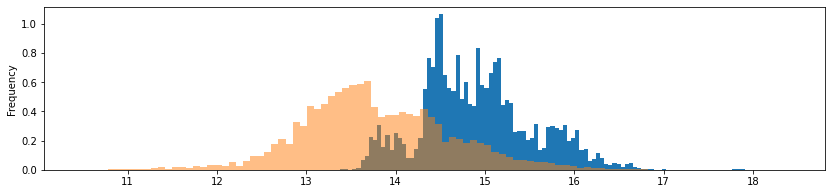

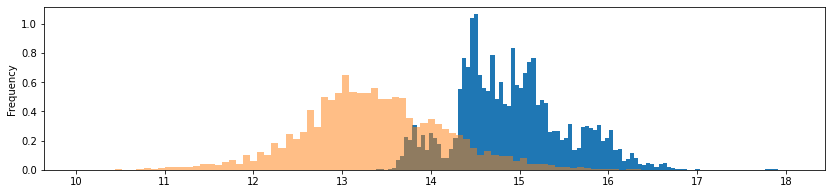

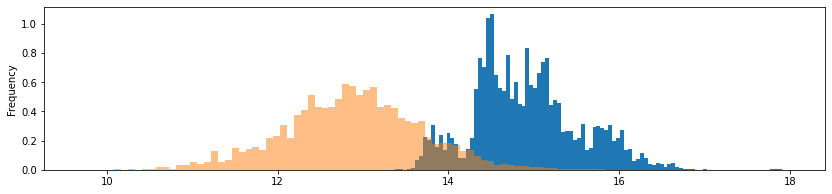

In [36]:
# if 1:
# # def missing_distribution():
#     plt.figure(figsize=(14,3))
#     log(train_0909_full_uni.price[train_0909_full_uni.Владельцы.isna()]).plot.hist(bins=100,density=True)
#     log(train_0909_full_uni.price[train_0909_full_uni.Владельцы == 1]).plot.hist(
#         bins=100,density=True,alpha = 0.5)
#     plt.figure(figsize=(14,3))
#     log(train_0909_full_uni.price[train_0909_full_uni.Владельцы.isna()]).plot.hist(bins=100,density=True)
#     log(train_0909_full_uni.price[train_0909_full_uni.Владельцы == 2]).plot.hist(
#         bins=100,density=True,alpha = 0.5)
#     plt.figure(figsize=(14,3))
#     log(train_0909_full_uni.price[train_0909_full_uni.Владельцы.isna()]).plot.hist(bins=100,density=True)
#     log(train_0909_full_uni.price[train_0909_full_uni.Владельцы == 3]).plot.hist(
#         bins=100,density=True,alpha = 0.5)